In [19]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from tqdm import tqdm 

### load & first clean

In [20]:
dff = pd.read_excel('Datensätze.xlsx')
dff.replace(0, float('NaN'), inplace=True)
dff.dropna(inplace=True)

### Formula to add Stock/Bond Ratio to df

In [21]:
def Add_SBRatioZ(df, n):
# calculate and add Stock/Bond Ratio Z Score
# first calculate all in a seperate 

    df['SB_Ratio'] = df['Stock_P']/df['Bond_P']
    df['SB_Ratio_MA'] = df['SB_Ratio'].rolling(n).mean()
    df['SB_Ratio_Z'] = ((df['SB_Ratio']-df['SB_Ratio_MA'])/df['SB_Ratio'].rolling(n).std())
    return df

### Formula to add RiskPremium to df

In [22]:
def Add_RiskPremiumZ(df, n):
# calculate risk premium Z Score

    df['Risk_Premium'] = ((df['Earnings']/df['SPX_P']) - df['US10Y_Yield'])*-1
    df['Risk_Premium_MA'] = df['Risk_Premium'].rolling(n).mean()
    df['Risk_Premium_Z'] = (df['Risk_Premium']-df['Risk_Premium_MA'])/df['Risk_Premium'].rolling(n).std()
    return df

### Formula to Add Put/Call Impl Vol to df

In [23]:
def Add_PutCallVolZ(df, n):
# calculate Put/Call Implied Volatility Z Score

    df['SPX_Impl_Spread_P-C_MA'] = (1/df['SPX_Impl_Spread_P-C']).rolling(n).mean()
    df['SPX_Impl_Spread_P-C_Z'] = ((1/df['SPX_Impl_Spread_P-C'])-df['SPX_Impl_Spread_P-C_MA'])/(1/df['SPX_Impl_Spread_P-C']).rolling(n).std()
    return df


### Formula to add High Yield CDS to df

In [24]:
def Add_HYCDSZ(df, n):
# calculate High Yield Credit Default Swap Z Score 
    
    df['HY_CDS_MA'] = df['HY_CDS'].rolling(n).mean()
    df['HY_CDS_Z'] = (df['HY_CDS']-df['HY_CDS_MA'])/df['HY_CDS'].rolling(n).std()
    return df

### Formula to add Vola Curve Slope Z Score to df

In [25]:
def Add_Vola_Curve_Z(df,n):
# calculate Vola Curve Z Score
    
    df['Vola_Slope_MA'] = df['Vola_Slope'].rolling(n).mean()
    df['Vola_Slope_Z'] = (df['Vola_Slope']-df['Vola_Slope_MA'])/df['Vola_Slope'].rolling(n).std()
    return df

In [28]:
def do_Strat(dff, n1=120, n2=120, n3=120, n4=120, n5=120):
    
# do the strategy and chose 

# copy the dataframe to use 
    df = dff.copy()

# calculate future Returns
    df['1M nReturn'] = np.log(df['Stock_P'].shift(-21)/df['Stock_P'].shift(-1))
    df['3M nReturn'] = np.log(df['Stock_P'].shift(-61)/df['Stock_P'].shift(-1))
    df['6M nReturn'] = np.log(df['Stock_P'].shift(-121)/df['Stock_P'].shift(-1))
    
# calculate values 
    df = Add_SBRatioZ(df, n1)
    df = Add_RiskPremiumZ(df, n2)
    df = Add_PutCallVolZ(df, n3)
    df = Add_HYCDSZ(df, n4)
    df = Add_Vola_Curve_Z(df, n5)
    

# create Score
    df['Score'] = df['SB_Ratio_Z']+df['Risk_Premium_Z']+df['SPX_Impl_Spread_P-C_Z']+df['Vola_Slope_Z']

    
# drop NaN    
    df.dropna(inplace=True)

    return df

Sell Return is -0.078 on average from 2 trades
Buy Return is 0.191 on average from 42 trades
The Average 1M Return is 0.059


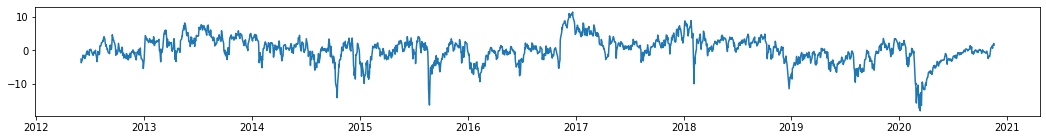

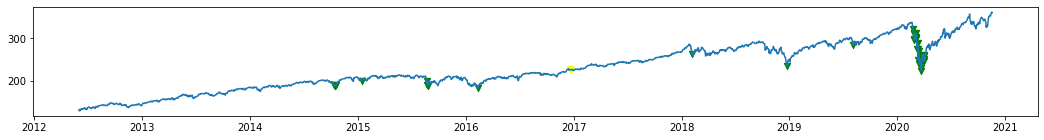

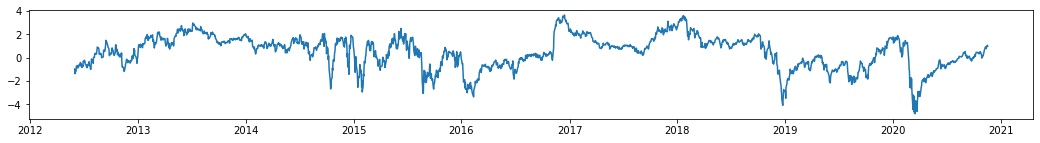

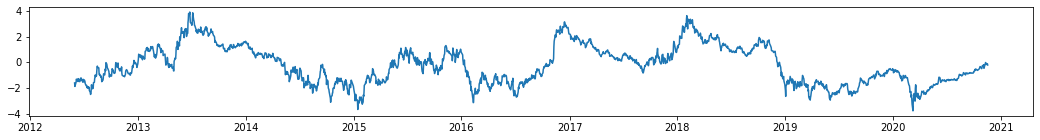

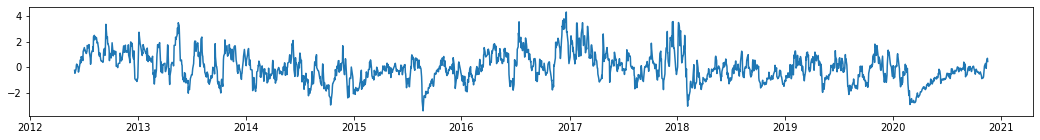

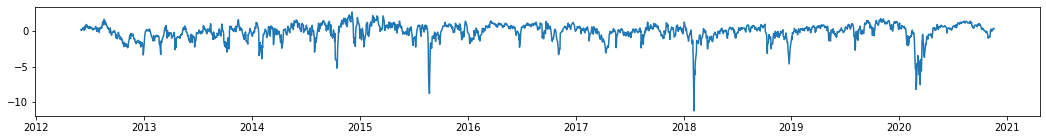

In [29]:
df = do_Strat(dff, 240, 240, 240, 240, 240)

df['SELL'] = df['Score'] > 11
df['BUY'] = df['Score'] < -9

print(f"Sell Return is {round(((df['6M nReturn']*df['SELL']*-1).sum()/df['SELL'].sum()),3)} on average from {df['SELL'].sum()} trades")
print(f"Buy Return is {round(((df['6M nReturn']*df['BUY']).sum()/df['BUY'].sum()),3)} on average from {df['BUY'].sum()} trades")
print(f"The Average 1M Return is {round(df['6M nReturn'].sum()/df['1M nReturn'].count(), 3)}")

plt.figure(figsize=(18, 2))
plt.plot(df['Date'], df['Score'])
plt.show()

plt.figure(figsize=(18, 2))
plt.plot(df['Date'], df['Stock_P'])
plt.scatter(df.loc[df['SELL'], 'Date'].values, df.loc[df['SELL'], 'Stock_P'].values, label='skitscat', color='yellow', s=40, marker="v")
plt.scatter(df.loc[df['BUY'], 'Date'].values, df.loc[df['BUY'], 'Stock_P'].values, label='skitscat', color='green', s=40, marker="v")
plt.show()

plt.figure(figsize=(18, 2))
plt.plot(df['Date'], df['SB_Ratio_Z'])
plt.show()

plt.figure(figsize=(18, 2))
plt.plot(df['Date'], df['Risk_Premium_Z'])
plt.show()

plt.figure(figsize=(18, 2))
plt.plot(df['Date'], df['SPX_Impl_Spread_P-C_Z'])
plt.show()

# plt.figure(figsize=(18, 2))
# plt.plot(df['Date'], df['HY_CDS_Z'])
# plt.show()

plt.figure(figsize=(18, 2))
plt.plot(df['Date'], df['Vola_Slope_Z'])
plt.show()

In [30]:
df.columns

Index(['Date', 'Fwd_Earnings', 'Stock_P', 'Stock_Vol', 'US10Y_Yield',
       'Put_Call', 'SPX_P', 'Bond_P', 'Earnings', 'Stock_Volume',
       'SPX_Impl_Spread_P-C', 'Dollar ', 'Vola_Slope', 'HY_CDS', '1M nReturn',
       '3M nReturn', '6M nReturn', 'SB_Ratio', 'SB_Ratio_MA', 'SB_Ratio_Z',
       'Risk_Premium', 'Risk_Premium_MA', 'Risk_Premium_Z',
       'SPX_Impl_Spread_P-C_MA', 'SPX_Impl_Spread_P-C_Z', 'HY_CDS_MA',
       'HY_CDS_Z', 'Vola_Slope_MA', 'Vola_Slope_Z', 'Score', 'SELL', 'BUY'],
      dtype='object')

In [13]:
np.linspace(5, 10, 3)

array([ 5. ,  7.5, 10. ])

In [14]:
result = pd.DataFrame(columns=['b',
                               'n1', 
                               'n2', 
                               'n3', 
                               'n4', 
                               'n5', 
                               '# Sell', 
                               '3MS', 
                               '6MS', 
                               '# Buy', 
                               '3MB', 
                               '6MB'])

n = 0

for f in tqdm(np.linspace(5, 10, 3)):
    for a in tqdm(np.linspace(120, 240, 3)):
        for b in tqdm(np.linspace(120, 240, 3)):
            for c in tqdm(np.linspace(120, 240, 3)):
                for d in tqdm(np.linspace(120, 240, 3)):
                    for e in tqdm(np.linspace(120, 240, 3)):
                        
                        df = do_Strat(df, int(a), int(b), int(c), int(d), int(e))

                        df['SELL'] = df['Score'] > f
                        df['BUY'] = df['Score'] < -f
                        
                        g = df['SELL'].sum()
                        
                        h = ((df['1M nReturn']*df['SELL']*-1).sum())/(df['SELL'].sum())
                        i = ((df['3M nReturn']*df['SELL']*-1).sum())/(df['SELL'].sum())
                        
                        j = df['BUY'].sum()
                        
                        k = ((df['3M nReturn']*df['BUY']*1).sum())/(df['BUY'].sum())
                        l = ((df['6M nReturn']*df['BUY']*1).sum())/(df['BUY'].sum())
                        
                        result = result.append(pd.Series([0]), ignore_index=True)
                        
                        result.iloc[n, 0] = f
                        result.iloc[n, 1] = b
                        result.iloc[n, 2] = c
                        result.iloc[n, 3] = d
                        result.iloc[n, 4] = e
                        result.iloc[n, 5] = a
                        result.iloc[n, 6] = g
                        result.iloc[n, 7] = h
                        result.iloc[n, 8] = i
                        result.iloc[n, 9] = j
                        result.iloc[n, 10] = k
                        result.iloc[n, 11] = l
                        
                        n += 1

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/3 [00:00<?, ?it/s]



  0%|          | 0/3 [00:00<?, ?it/s]




  0%|          | 0/3 [00:00<?, ?it/s]


NameError: name 'df' is not defined

In [15]:
result.to_excel('result_new.xlsx')